In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ratios

In [2]:
ratios = pd.read_csv(Path('data', 'financialratios.csv'), sep='	')

# convert dates to pandas datetime, only keeping date of publication
ratios['date'] = pd.to_datetime(ratios['public_date'], format='%d%b%Y') + pd.tseries.offsets.MonthEnd(0)
ratios = ratios.drop(['adate', 'qdate', 'public_date'], axis=1)

old_ratios = ratios.copy()

# remove columns with more than max_na missing values
max_na = 20_000
ratios = ratios.dropna(axis=1, thresh=len(ratios)-max_na)

# remove rows still missing values
ratios = ratios.dropna()

Text(0.5, 1.0, 'Observations over time')

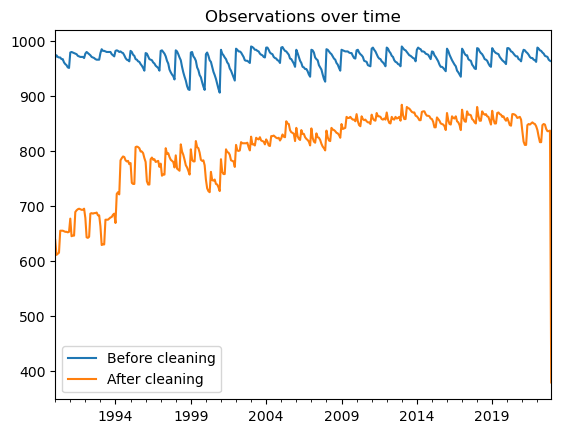

In [4]:
observations = pd.concat([
    old_ratios['date'].value_counts().rename('Before cleaning'),
    ratios['date'].value_counts().rename('After cleaning')],
    axis=1)

fig, ax = plt.subplots()
observations.plot(ax=ax)
ax.set_title('Observations over time')

# Prices

In [5]:
prices = pd.read_csv(
    Path('data', 'crsp_top1000.csv'),
    sep='	',
    low_memory=False)

# convert dates to pandas datetime remove other formats,
# settings dates to last of month to match ratios
prices['date'] = pd.to_datetime(prices['date'], format='%d%b%Y') + pd.tseries.offsets.MonthEnd(0)
prices = prices.drop(['year', 'month'], axis=1)

# convert returns to numpy float
prices['ret'] = (
    pd.to_numeric(
        # fix decimal strings
        prices['ret'].str.replace('.','0.', regex=False),
        # force errors to nans
        errors='coerce'
    # drop nans
    ).dropna()
)

# Clean and save

In [6]:
# move sic2 to ratios
sectors = prices[['permno', 'sic2']].groupby('permno')['sic2'].first()
prices = prices.drop('sic2', axis=1)
ratios = ratios.merge(sectors, left_on='permno', right_index=True, how='inner')

In [7]:
# save to pickles
prices.to_pickle(Path('data', 'cleaned_prices.pkl'))
ratios.to_pickle(Path('data', 'cleaned_ratios.pkl'))